# Visual content based recommendation
_**Using a Convolutional Neural Net and Elasticsearch KNN to recommend visually similar images**_

---

---

## Contents


1. [Background](#Background)
1. [Setup](#Setup)
1. [TensorFlow Model Preparation](#TensorFlow-Model-Preparation)
1. [SageMaker Model Hosting](#Hosting-Model)
1. [Build a KNN Index in Elasticsearch](#ES-KNN)
1. [Evaluate Index Search Results](#Searching-with-ES-k-NN)
1. [Extensions](#Extensions)

## Background

In this notebook, we'll build the core components of a visual content based recommendation. Visual content based recommendation is used in interfaces where instead of asking for something by voice or text, you show what you are looking for.

One of the core components of visual content based recommendation is a convolutional neural net (CNN) model that generates “feature vectors” representing both a query image and the reference item images to be compared against the query. The reference item feature vectors typically are generated offline and must be stored in. So they can be efficiently searched. For small reference item datasets, it is possible to use a brute force search that compares the query against every reference item. However, this is not feasible for large data sets where brute force search would become prohibitively slow. 

To enable efficient searches for visually similar images, we'll use Amazon SageMaker to generate “feature vectors” from images and use KNN algorithim in Amazon Elasticsearch service. KNN for Amazon Elasticsearch Service lets you search for points in a vector space and find the "nearest neighbors" for those points by Euclidean distance. Use cases include recommendations (for example, an "other songs you might like" feature in a music application), image recognition, and fraud detection.

Here are the steps we'll follow to build the visual content based recommendation: After some initial setup, we'll prepare a model using TensorFlow for generating feature vectors, then generate feature vectors from *__Caltech101__* dataset. Those feature vectors will be imported in Amazon Elasticsearch KNN Index. Next, we'll explore some test image queries, and visualize the results.

## Setup

Prerequisite for this workshop:

1. **Create S3 bucket**: Create an Amazon S3 bucket on the same region as the SageMaker Notebook Instance. This bucket will store all the *__Caltech101__* dataset
1. **Setup IAM role**: Create a IAM role with *__AmazonSageMakerFullAccess__* and also create an inline policy to have *__GetObject__* & *__PutObject__* permission on the bucket
1. **Prepare the dataset**: Upload the  *__Caltech101__* dataset in S3 bucket
1. **Create Amazon Elasticsearch domain**: Create an Amason Elasticsearch domain with version 7.1 or later
1. **Configure Amazon Elasticsearch domain**: Do the IAM role mapping in Amazon Elasticsearch using Kibana endpoint.


In [ ]:
## Importing necessary library
import boto3
import re
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()

In [ ]:
## Data Preparation

import os 
import shutil
import urllib.request

dirName = 'Caltech101'
#download dataset to local notebook
def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)


#upload dataset to s3
def upload_to_s3(bucket, file):
    s3_resource = boto3.resource("s3")
    my_bucket = s3_resource.Bucket(bucket)
    for path, subdirs, files in os.walk('./' + dirName):
        path = path.replace("\\","/")
        directory_name = path.replace('./',"")
        for file in files:
            my_bucket.upload_file(os.path.join(path, file), directory_name+'/'+file)
    
# caltech-101
bucket = '<<YOUR_OWN_BUCKET_NAME>>' # put your own bucket name

download('http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz')

dirName = 'Caltech101'
if not os.path.exists(dirName):
    os.makedirs(dirName)
    print("Directory " , dirName ,  " Created ")
else:    
    print("Directory " , dirName ,  " already exists") 

#untar the caltech101 dataset
!tar -C Caltech101 -xvf 101_ObjectCategories.tar.gz

#remove the clutter file from the system
dirName = './Caltech101/101_ObjectCategories/BACKGROUND_Google'
if os.path.exists(dirName):
    shutil.rmtree(dirName)
    print("Directory " , dirName ,  " deleted ")


upload_to_s3(bucket, 'Caltech101') # this process will take 15 min to upload all the dataset

In [ ]:
#Install tqdm to have progress bar
!pip install tqdm

## TensorFlow Model Preparation

We'll use TensorFlow backend to prepare a model for "featurizing" images into feature vectors. TensorFlow has a native Module API, as well as a higher level Keras API. 

We will start with a pretrained model, avoiding spending time and money training a model from scratch. Accordingly, as a first step in preparing the model, we'll import a pretrained model from Keras application. Researchers have experimented with various pretrained CNN architectures with different numbers of layers, discovering that there are several good possibilities.

In this notebook, we'll select a model based on the ResNet architecture, a commonly used choice. Of the various choices for number of layers, ranging from 18 to 152, we'll use 50 layers. This also is a common choice that balances the expressiveness of the resulting feature vectors (embeddings) against computational efficiency (lower number of layers means greater efficiency at the cost of less expressiveness).

In [ ]:
import os
import json
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import sagemaker
from PIL import Image
from sagemaker.tensorflow import TensorFlow

In [ ]:
# Set the channel first for better performance
from tensorflow.keras import backend
backend.set_image_data_format('channels_first')
print(backend.image_data_format())

channels_first


Now we'll get a reference ResNet50 model which is trained on Imagenet dataset to extract the feature without the actual clssifier. More specifically, we'll use that layer to generate a row vector of floating point numbers as an "embedding" or representation of the features of the image. We'll also save the model as *SavedModel* format under **export/Servo/1** to serve from SageMaker TensorFlow serving API.

In [ ]:
#Import Resnet50 model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,input_shape=(3, 224, 224),pooling='avg')


In [ ]:
model.summary()

In [ ]:
#Creating the directory strcture
dirName = 'export/Servo/1'
if not os.path.exists(dirName):
    os.makedirs(dirName)
    print("Directory " , dirName ,  " Created ")
else:    
    print("Directory " , dirName ,  " already exists")    

In [ ]:
#Save the model in SavedModel format
model.save('./export/Servo/1/', save_format='tf')

In [ ]:
#Check the model Signature
!saved_model_cli show --dir ./export/Servo/1/ --tag_set serve --signature_def serving_default

## SageMaker Model Hosting

After saving the feature extractor model we will deploy the model using Sagemaker Tensorflow Serving api which is a flexible, high-performance serving system for machine learning models, designed for production environments.TensorFlow Serving makes it easy to deploy new algorithms and experiments, while keeping the same server architecture and APIs. TensorFlow Serving provides out-of-the-box integration with TensorFlow models, but can be easily extended to serve other types of models and data. We will define **inference.py** to customize the input data to TensorFlow serving API. We also need to add **requirements.txt** file for aditional libraby in the tensorflow serving container.

In [ ]:
%%writefile ./src/inference.py

import io
import json
import base64
import numpy as np
import tensorflow as tf
from collections import namedtuple
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from PIL import Image

HEIGHT = 224
WIDTH  = 224

Context = namedtuple('Context',
                     'model_name, model_version, method, rest_uri, grpc_uri, '
                     'custom_attributes, request_content_type, accept_header')

def input_handler(data, context):
    """ Pre-process request input before it is sent to TensorFlow Serving REST API
    Args:
        data (obj): the request data, in format of dict or string
        context (Context): an object containing request and configuration details
    Returns:
        (dict): a JSON-serializable dict that contains request body and headers
    """
    if context.request_content_type == 'application/x-image':
        # pass through json (assumes it's correctly formed)
        #read image as bytes
        image_as_bytes = io.BytesIO(data.read())
        print (image_as_bytes)
        img = Image.open(image_as_bytes)
        img = img.resize((WIDTH, HEIGHT))
        # convert PIL image instance to numpy array
        img_array = image.img_to_array(img, data_format = "channels_first")
        print (img_array.shape)
        # the image is now in an array of shape (3, 224, 224)
        # need to expand it to (1, 3, 224, 224) as it's expecting a list
        expanded_img_array = tf.expand_dims(img_array, axis=0)
        print (expanded_img_array.shape)
        #preprocessing the image array
        preprocessed_img = preprocess_input(expanded_img_array, data_format = "channels_first")
        print (preprocessed_img.shape)
        #changing the channel at first
        #channel_first_preprocessed_img = np.moveaxis(preprocessed_img, -1, 1)
        #print (channel_first_preprocessed_img.shape)
        #converting to numpy list
        #preprocessed_img_lst = channel_first_preprocessed_img.tolist()
        preprocessed_img_lst = preprocessed_img.numpy().tolist()
        return json.dumps({"instances": preprocessed_img_lst})
    else:
        _return_error(415, 'Unsupported content type "{}"'.format(context.request_content_type or 'Unknown'))

    if context.request_content_type == 'text/csv':
        # very simple csv handler
        return json.dumps({
            'instances': [float(x) for x in data.read().decode('utf-8').split(',')]
        })

    raise ValueError('{{"error": "unsupported content type {}"}}'.format(
        context.request_content_type or "unknown"))


def output_handler(data, context):
    """Post-process TensorFlow Serving output before it is returned to the client.
    Args:
        data (obj): the TensorFlow serving response
        context (Context): an object containing request and configuration details
    Returns:
        (bytes, string): data to return to client, response content type
    """
    if data.status_code != 200:
        raise ValueError(data.content.decode('utf-8'))

    response_content_type = context.accept_header
    prediction = data.content
    return prediction,response_content_type

def _return_error(code, message):
    raise ValueError('Error: {}, {}'.format(str(code), message))

In [ ]:
#zip the model .gz format
model_version = '1'
export_dir = 'export/Servo/' + model_version
import tarfile
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('export', recursive=True)

In [ ]:
#Upload the model to S3
sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')
inputs

After we upload the model to S3 we will use TensorFlow serving container to host the model. We are using ml.p3.16xlarge instance type. You may need to raise support ticket to increase the Service quotas for SageMaker hosting instance type. We will use this endpoint to generate features and import into ElasticSearch. you can also choose small instance such as "ml.m4.xlarge" to save cost.

In [ ]:
#Deploy the model in Sagemaker Endpoint. This process will take ~10 min.
from sagemaker.tensorflow.serving import Model
sagemaker_model = Model(entry_point='inference.py', model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
                                  role = role, framework_version='2.1.0', source_dir='./src' )

predictor = sagemaker_model.deploy(initial_instance_count=1, instance_type='ml.p3.16xlarge')



In [ ]:
#Define some utility function to read file from S3

import s3fs
from s3fs.core import S3FileSystem
#read a file stored in s3
def read_file(img_path):
    s3 = s3fs.S3FileSystem(anon=False)
    data = s3.open(img_path,mode='rb')
    return data

In [ ]:
# get the features for a smaple image
payload = read_file('s3://caltech101-dataset/Caltech101/101_ObjectCategories/Faces/image_0002.jpg')
predictor.content_type = 'application/x-image'
predictor.serializer   = None
features = predictor.predict(payload)['predictions'][0]

features

## Build a KNN Index in Elasticsearch

KNN for Amazon Elasticsearch Service lets you search for points in a vector space and find the "nearest neighbors" for those points by Euclidean distance. Use cases include recommendations (for example, an "other songs you might like" feature in a music application), image recognition, and fraud detection.

KNN requires Elasticsearch 7.1 or later. Full documentation for the Elasticsearch feature, including descriptions of settings and statistics, is available in the Open Distro for Elasticsearch documentation. For background information about the k-nearest neighbors algorithm

In this step we'll get all the features Caltech101 images and import those features into Elastichseach7.4 domain.

In [ ]:
#Define some utility function

#return all s3 keys
def get_all_s3_keys(bucket):
    """Get a list of all keys in an S3 bucket."""
    s3 = boto3.client('s3')
    keys = []

    kwargs = {'Bucket': bucket}
    while True:
        resp = s3.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            keys.append('s3://' + bucket + '/' + obj['Key'])

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

    return keys
 

In [ ]:
bucket = '<<YOUR_OWN_BUCKET>>'  # customize to your bucket (e.g: caltech101-dataset)
# get all the cltech256 images keys from the bucket make a list
s3_uri = get_all_s3_keys(bucket)

In [ ]:
# define a function to extract image features
 
def extract_features(s3_uri):
    payload = read_file(s3_uri)
    predictor.content_type = 'application/x-image'
    predictor.serializer   = None
    feature_lst = predictor.predict(payload)['predictions'][0]
    return s3_uri, feature_lst


In [ ]:
# This multi process will take around 20min to complete in ml.p3.16xlarge instance as a SageMaker Endpoint.
import time
import multiprocessing
from multiprocessing import Pool

start_time = time.time()
CPU_COUNT = multiprocessing.cpu_count()
# Using 2x due to HyperThreading.
MAX_NUMBER_OF_PROCESSES = 2 * CPU_COUNT
pool = Pool(processes=MAX_NUMBER_OF_PROCESSES) 
result = pool.map(extract_features, s3_uri)    
elapsed_time = time.time() - start_time
elapsed_time


In [ ]:
#install necessary pkg to make connection with elasticsearch domain
! pip install elasticsearch
! pip install requests
! pip install requests-aws4auth

In [ ]:
# setting up the Elasticsearch connection
from elasticsearch import Elasticsearch, RequestsHttpConnection
from requests_aws4auth import AWS4Auth
host = '<<ELASTICSEARCH_DOMAIN_ENDPOINT>>' # For example, search-knndomain-ztdb23l3rfnsgacqgbisorrz5i.us-east-1.es.amazonaws.com
region = 'us-east-1' # e.g. us-east-1
service = 'es'
credentials = boto3.Session().get_credentials()
awsauth = AWS4Auth(credentials.access_key, credentials.secret_key, region, service, session_token=credentials.token)

es = Elasticsearch(
    hosts = [{'host': host, 'port': 443}],
    http_auth = awsauth,
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection
)

In [ ]:
#Define KNN Elasticsearch index maping
knn_index = {
    "settings": {
        "index.knn": True
    },
    "mappings": {
        "properties": {
            "caltech101_vector": {
                "type": "knn_vector",
                "dimension": 2048
            }
        }
    }
}

In [ ]:
#Creating the Elasticsearch index
es.indices.create(index="idx_caltech101",body=knn_index,ignore=400)
es.indices.get(index="idx_caltech101")

In [ ]:
# defining a function to import the feature vectors corrosponds to each S3 URI into Elasticsearch KNN index
# This process will take around ~3 min.
import tqdm
def es_import():
    for i in tqdm.tqdm_notebook(range(len(result))):
        es.index(
                 index='idx_caltech101',
                 body={"caltech101_vector": result[i][1], 
                       "image": result[i][0]})

es_import()

## Evaluate Index Search Results

In this step we will use SageMaker SDK as well as Boto3 SDK to query the Elasticsearch to retrive the nearest neighbours. One thing to mention **Caltech101** dataset has pretty good similarity with Imagenet dataset. Now if you hav a very domain speific problem then then you need to train that dataset on top of pretrained feature extractor model such as VGG, Resnet, Xeception, Mobilenet etc and bulid a new feature extractor model.

In [ ]:
#define display_image function
def display_image(bucket, key):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket)
    object = bucket.Object(key)
    response = object.get()
    file_stream = response['Body']
    img = Image.open(file_stream)
    return display(img)

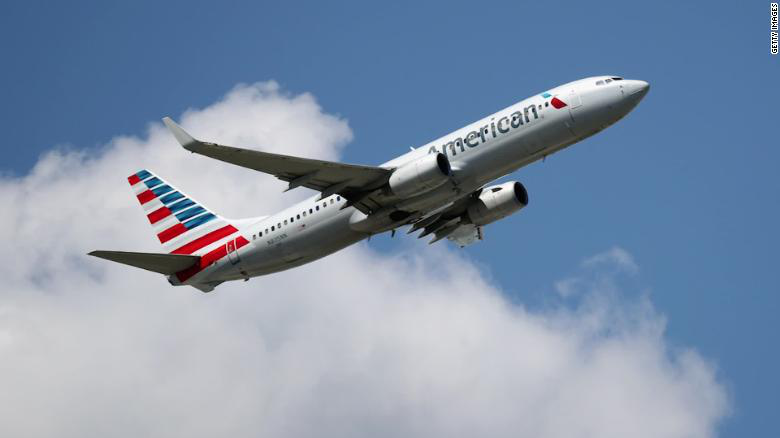

In [ ]:
import requests
import random
from PIL import Image
import io
urls = []
# Plane
urls.append('https://cdn.cnn.com/cnnnext/dam/assets/190906095526-american-airlines-mechanic-faces-sabotage-charge-marsh-nr-vpx-00000225-exlarge-169.jpg')
# Computer
urls.append('https://i5.walmartimages.com/asr/a5e69e8c-ce8e-4c44-bed9-62c5f93c5ad9_1.1cb03caf7d00a7581f0b74d96dea4578.jpeg')
#Bike
urls.append('https://previews.123rf.com/images/rawpixel/rawpixel1504/rawpixel150408434/39108718-motorcycle-motorbike-bike-riding-rider-contemporary-purple-concept.jpg')

img_bytes = requests.get(random.choice(urls)).content
query_img = PIL.Image.open(io.BytesIO(img_bytes))
query_img

###### SageMaker SDK Method

In [ ]:
#SageMaker SDK approach
predictor.content_type = 'application/x-image'
predictor.serializer   = None
features = predictor.predict(img_bytes)['predictions'][0]

In [ ]:
import json
k = 5
idx_name = 'idx_caltech101'
res = es.search(request_timeout=30, index=idx_name,
                body={'size': k, 
                      'query': {'knn': {'caltech101_vector': {'vector': features, 'k': k}}}})

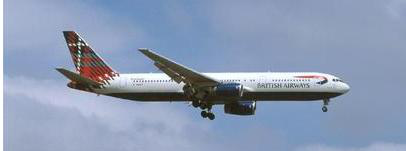

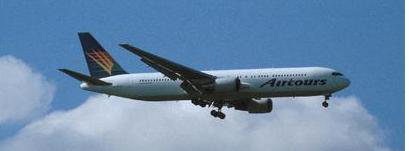

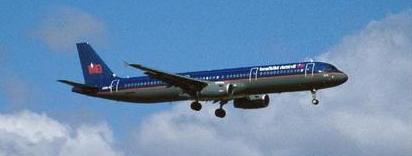

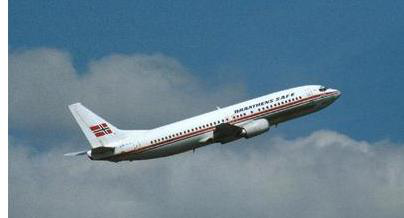

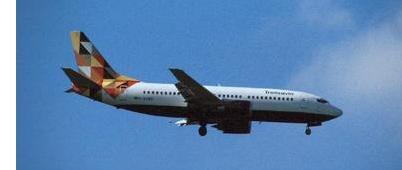

In [ ]:
bucket = 'caltech101-dataset'
for i in range(k):
    key = res['hits']['hits'][i]['_source']['image']
    key = key.replace('s3://caltech101-dataset/','')
    img = display_image (bucket,key)

##### Boto3 Method

In [ ]:
client = boto3.client('sagemaker-runtime')
payload = bytearray(img_bytes)
ENDPOINT_NAME = '<<SAGEMAKER-ENDPOINT-NAME>>' # Example'tensorflow-inference-2020-04-27-17-19-09-737'
response = client.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                       ContentType='application/x-image',
                                       Body=payload)

response_body = json.loads((response['Body'].read()))
features = response_body['predictions'][0]



In [ ]:
import json
k = 5
idx_name = 'idx_caltech101'
res = es.search(request_timeout=30, index=idx_name,
                body={'size': k, 
                      'query': {'knn': {'caltech101_vector': {'vector': features, 'k': k}}}})


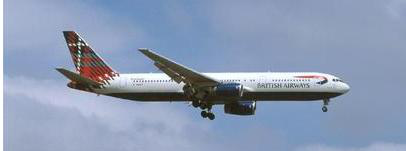

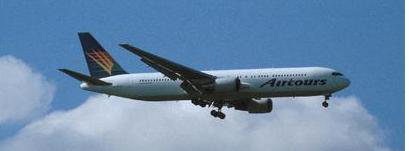

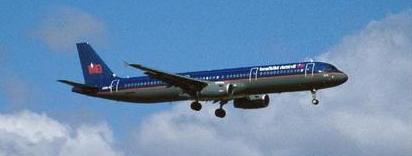

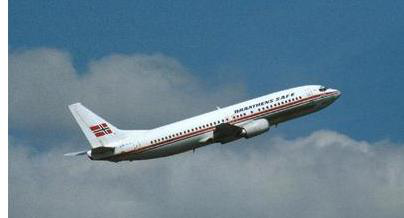

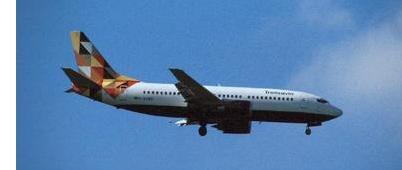

In [ ]:
bucket = 'caltech101-dataset'
for i in range(k):
    key = res['hits']['hits'][i]['_source']['image']
    key = key.replace('s3://caltech101-dataset/','')
    img = display_image (bucket,key)

## Extensions

We have used pretrained Resnet50 model which is trained on Imagenet dataset.  Now if you have very specific domain specific problem let's say you are doing item recomendation on retail industry then you need to tune the feature extractor model with your own data using transfer learning. In that case use pretrained model and then add the Dense Layer with actual clasifer and then freezed few layes and retrain the model in SageMaker. Then poped the clasifer layer from the actual trained CNN model, so that it will be a true feature extractor model for your use case and then  host the model in Amazon SageMaker.

You can also use Amazon SageMaker Batch transform job to have a bulk feaures extracted from your stored S3 images and then you can use AWS Glue to import that data into Elasticeearch domain.

Once you have this kind of visual content based recommmender system implemented for your website then you can collect all the click stream data to have more robust hybrid recommender system using **Amazon Personalize**.

### Cleanup

Make sure that you stop the notebook instance, delete the Amazon SageMaker endpoint and delete the Elasticsearch domain to prevent any additional charges.

# README

## Visual content recommender

This repository guides users through creating a visual content recommender/search to search similar images using Amazon SageMaker and Amazon Elasticsearch

## How does it work?

Each reference image from Caltech101 dataset is represented as a 2048 feature vector using a convolutional neural networks and gets stored into Amazon Elasticsearch KNN index

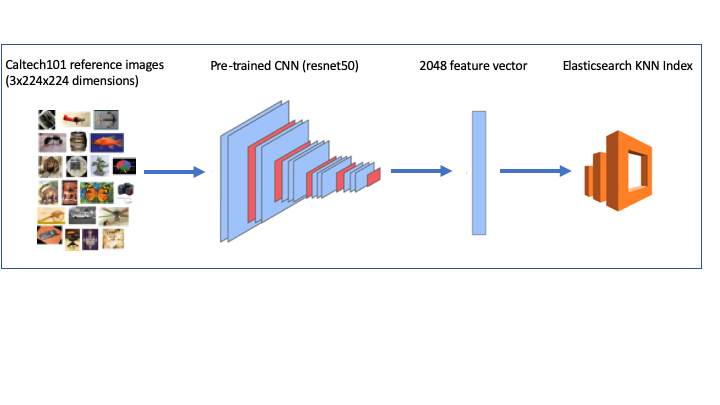

When we present a new query image, it's computing the related feature vector from Amazon SageMaker hosted model and query Amazon Elasticsearch KNN index to find similar images

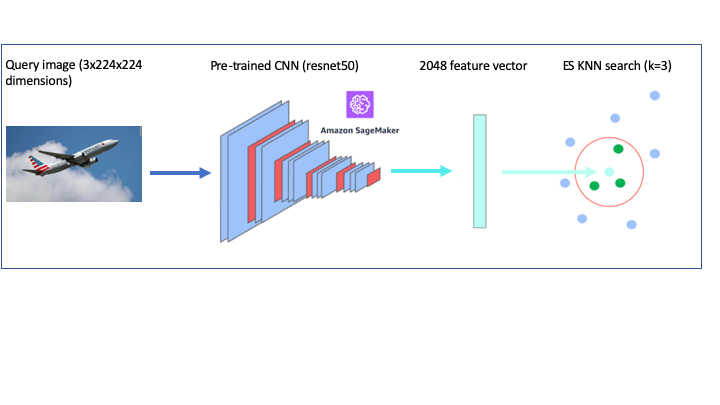